In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import csv
import pandas as pd
from sklearn.model_selection import train_test_split

Take data file and convert class names to class numbers 

In [2]:
df = pd.read_csv('data/Amazon-Products.csv')

class_labels = df['sub_category']

unique_classes = class_labels.unique()

# Map class labels to numbers
class_to_number = {class_label: idx for idx, class_label in enumerate(unique_classes)}

# Replace class labels with numbers
df['class_numbers'] = df['sub_category'].map(class_to_number)

# Save the modified dataframe to a new CSV file
df.to_csv('data.csv', index=False)

print(class_to_number)


{'Air Conditioners': 0, 'All Appliances': 1, 'All Car & Motorbike Products': 2, 'All Electronics': 3, 'All Exercise & Fitness': 4, 'All Grocery & Gourmet Foods': 5, 'All Home & Kitchen': 6, 'All Pet Supplies': 7, 'All Sports, Fitness & Outdoors': 8, 'Amazon Fashion': 9, 'Baby Bath, Skin & Grooming': 10, 'Baby Fashion': 11, 'Baby Products': 12, 'Backpacks': 13, 'Badminton': 14, 'Bags & Luggage': 15, 'Ballerinas': 16, 'Beauty & Grooming': 17, 'Bedroom Linen': 18, 'Camera Accessories': 19, 'Cameras': 20, 'Camping & Hiking': 21, 'Car & Bike Care': 22, 'Car Accessories': 23, 'Car Electronics': 24, 'Car Parts': 25, 'Cardio Equipment': 26, 'Casual Shoes': 27, 'Clothing': 28, 'Coffee, Tea & Beverages': 29, 'Cricket': 30, 'Cycling': 31, 'Diapers': 32, 'Diet & Nutrition': 33, 'Dog supplies': 34, 'Ethnic Wear': 35, 'Fashion & Silver Jewellery': 36, 'Fashion Sales & Deals': 37, 'Fashion Sandals': 38, 'Fitness Accessories': 39, 'Football': 40, 'Formal Shoes': 41, 'Furniture': 42, 'Garden & Outdoors

Read converted data file and store text and classes in arrays

In [3]:
def read_column_from_csv(csv_file, column_number):
    with open(csv_file, mode='r', encoding='utf-8') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)  # Skip the header row
        for row in csv_reader:
            if len(row) > column_number:
                yield row[column_number]

csv_file = "data.csv"

train_labels = []
train_texts = []
count = 0

for value in read_column_from_csv(csv_file, 10):
    train_labels.append(int(value))
    count += 1

for value in read_column_from_csv(csv_file, 1):
    train_texts.append(value)

number = len(train_labels)

print(f"Products: {number}")
print(len(train_texts))
print(len(train_labels))

Products: 551585
551585
551585


Test/Train Split

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_texts, validation_texts, train_labels, validation_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42)

# You can check the sizes of the sets
print("Training set size:", len(train_texts))
print("Testing set size:", len(validation_texts))

Training set size: 441268
Testing set size: 110317


Train the model and save it

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Dylan Kangas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Using batch size: 64
Epoch 1/15


Epoch 1/15, Avg. Loss: 1.2511
Epoch 2/15


Epoch 2/15, Avg. Loss: 0.7803
Epoch 3/15


Epoch 3/15, Avg. Loss: 0.6903
Epoch 4/15


Epoch 4/15, Avg. Loss: 0.6345
Epoch 5/15


Epoch 5/15, Avg. Loss: 0.5916
Epoch 6/15


Epoch 6/15, Avg. Loss: 0.5553
Epoch 7/15


Epoch 7/15, Avg. Loss: 0.5247
Epoch 8/15


Epoch 8/15, Avg. Loss: 0.4971
Epoch 9/15


Epoch 9/15, Avg. Loss: 0.4725
Epoch 10/15


Epoch 10/15, Avg. Loss: 0.4495
Epoch 11/15


Epoch 11/15, Avg. Loss: 0.4295
Epoch 12/15


Epoch 12/15, Avg. Loss: 0.4126
Epoch 13/15


Epoch 13/15, Avg. Loss: 0.3964
Epoch 14/15


Epoch 14/15, Avg. Loss: 0.3824
Epoch 15/15


Epoch 15/15, Avg. Loss: 0.3692


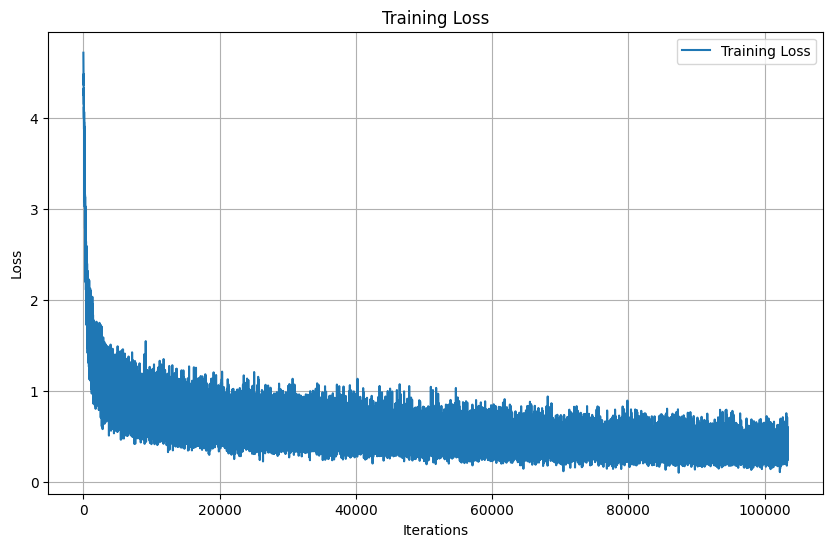

In [7]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

num_epochs = 15
max_length = 128
initial_batch_size = 64

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the pre-trained BERT model and move it to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=112).to(device)

# Define your dataset class
class MyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


# Determine a suitable batch size
current_batch_size = initial_batch_size
while True:
    try:
        train_dataset = MyDataset(train_texts, train_labels, tokenizer, max_length)
        train_dataloader = DataLoader(train_dataset, batch_size=current_batch_size, shuffle=True)
        break
    except Exception as e:
        print(f"Batch size {current_batch_size} failed with error: {e}")
        current_batch_size //= 2
        print(f"Trying batch size {current_batch_size}")

print(f"Using batch size: {current_batch_size}")

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training loop with progress bars and loss collection
model.train()
losses = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    epoch_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        losses.append(loss.item())  # Append the current loss to the list

        progress_bar.set_postfix({'loss': epoch_loss / len(train_dataloader)})

        
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg. Loss: {avg_epoch_loss:.4f}")
    # Save the model
    model.save_pretrained("model/epoch" + str(epoch+1) + "/")

    
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the modell
model.save_pretrained("model/")

Test Accuracy

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Evaluation
model.eval()
total_correct = 0
total_samples = 0

# validation_texts = ["Star Wars Epic Hero Series Darth Vader 4 Action Figure", "Nerf Elite 2.0 Commander RD-6 Blaster, 12 Official Nerf Darts, 6-Dart Rotating Drum, Built-In Customizing Capabilities", "Auto Drive Car Wash Microfiber Sponge, Chenille Pile & Scrubber Back, Blue, 1 piece", "VIKING Wheel Brush for Rims, Cleaning Brush for Tires, Tire Brush for Car, Grey, 10.3 inch x 3.3 inch x 3.8 Inch"]
# validation_labels = [1, 1, 0, 0]  # Example labels for validation, replace with your actual labels

validation_dataset = MyDataset(validation_texts, validation_labels, tokenizer, max_length)
validation_dataloader = DataLoader(validation_dataset, batch_size=8, shuffle=False)

with torch.no_grad():
    for batch in validation_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        total_correct += torch.sum(predictions == labels).item()
        total_samples += len(labels)

print(predictions.tolist())
accuracy = total_correct / total_samples
print("Validation Accuracy:", accuracy)

[45, 19, 61, 73, 109]
Validation Accuracy: 0.7422428093584851
